In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.options.mode.chained_assignment = None  # default='warn'


pd.set_option('display.max_columns', None)




In [2]:
data  = pd.read_pickle('binaryIV_results.pkl')

<Axes: ylabel='Frequency'>

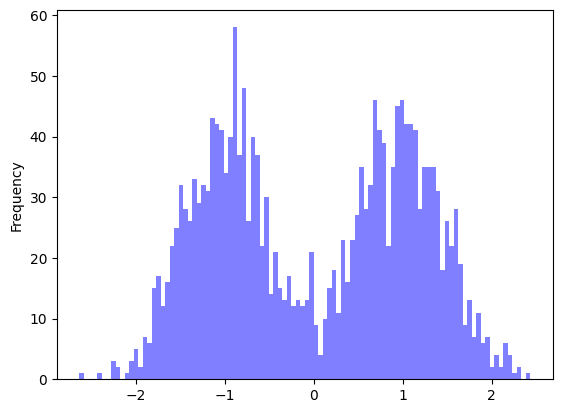

In [4]:
data['b_Z'].plot(kind='hist', bins=100, alpha=0.5, label='b_Z', color='blue')

In [6]:
print(data.columns.tolist())


['seed', 'intercept_X', 'intercept_Y', 'b_X_Y', 'b_Z', 'b_U_X', 'b_U_Y', 'ATE_true', 'p_Y1', 'p_Y0', 'Z', 'U', 'X', 'Y', 'entropy_Y', 'entropy_X', 'entropy_Z', 'entropy_U', 'corr_X_Y', 'corr_X_Z', 'corr_Y_Z', 'causaloptim_bound_lower', 'causaloptim_bound_upper', 'causaloptim_bound_width', 'causaloptim_bounds_valid', '2SLS_CI_level_percent', '2SLS_estimation', '2SLS_CI_lower', '2SLS_CI_upper', '2SLS_CI_width', '2SLS_CI_valid', 'entropyBounds_H(conf)_UB', 'entropyBounds_bound_lower', 'entropyBounds_bound_upper', 'entropyBounds_bound_width', 'entropyBounds_bounds_valid', 'autobound_bound_lower', 'autobound_bound_upper', 'autobound_bound_width', 'autobound_bounds_valid']


In [30]:
sim = data.iloc[300]

X = sim['X']
Y = sim['Y']
Z = sim['Z']
# Create a DataFrame from the arrays
df = pd.DataFrame({'X': X, 'Y': Y})

# Save the DataFrame to a CSV file
csv_file_path = "data300_idx_noZ.csv"
df.to_csv(csv_file_path, index=True)

# csv_file_path
print(f"{sim['ATE_true']:.6f}")
print(f"{sim['b_X_Y']:.6f}")




-0.344241
-3.500000


In [16]:
import numpy as np
from collections import Counter


X = data.iloc[0]['X']
Y = data.iloc[0]['Y']
Z = data.iloc[0]['Z']

N = len(X)

# Estimate empirical distributions
pz = np.bincount(Z, minlength=2) / N

# P(X | Z)
pxz_counts = Counter((z, x) for z, x in zip(Z, X))
px_given_z = np.array([
    [pxz_counts[(z, x)] for x in [0, 1]] for z in [0, 1]
], dtype=float)
px_given_z /= px_given_z.sum(axis=1, keepdims=True)

# P(Y | X)
pyx_counts = Counter((x, y) for x, y in zip(X, Y))
py_given_x = np.array([
    [pyx_counts[(x, y)] for y in [0, 1]] for x in [0, 1]
], dtype=float)
py_given_x /= py_given_x.sum(axis=1, keepdims=True)

# Create UAI file content
lines = []

# Header
lines.append("CAUSAL")
lines.append("3")  # number of variables: Z, X, Y
lines.append("2 2 2")  # cardinalities

# Factors: P(Z), P(X|Z), P(Y|X)
lines.append("3")  # number of factors
lines.append("1 0")       # P(Z)
lines.append("2 1 0")     # P(X | Z)
lines.append("2 2 1")     # P(Y | X)

# Factor sizes
lines.append("2")  # P(Z)
lines.append("4")  # P(X|Z): 2 Z values * 2 X values
lines.append("4")  # P(Y|X): 2 X values * 2 Y values

# Factor tables
lines.append(" ".join(f"{p:.5f}" for p in pz))  # P(Z)

# P(X | Z)
lines.append(" ".join(f"{p:.5f}" for p in px_given_z.flatten()))

# P(Y | X)
lines.append(" ".join(f"{p:.5f}" for p in py_given_x.flatten()))

# Save to file
uai_content = "\n".join(lines)
file_path = "binary_iv_model.uai"
with open(file_path, "w") as f:
    f.write(uai_content)

file_path

'binary_iv_model.uai'